In [5]:
# импортируем библиотеки
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.predict import model_from_checkpoint_path
%matplotlib inline

Using TensorFlow backend.


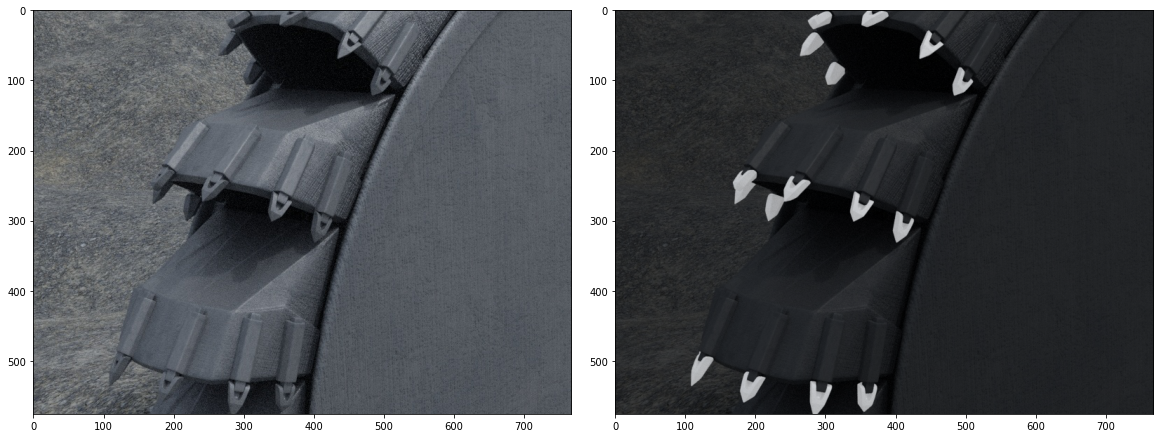

In [6]:
# отображаем маски поверх изображения
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

original = Image.open('dataset/imgs/Image0001.jpg')
mask = Image.open('dataset/masks/Image0001.png')

axs[0].imshow(original)
axs[1].imshow(original)
axs[1].imshow(mask, alpha = 0.6)

In [7]:
def show_pixel_values(array: np.array) -> dict():
    """
    Возвращает словарь показывающий сколько раз
    каждый пиксель встречается в изображении
    """
    d = dict()
    for row in array:
        for cell in row:
            cell = tuple(cell)
            if cell not in d:
                d[cell] = 1
            else:
                d[cell] += 1
    return d

mask_array = np.array(mask)
show_pixel_values(mask_array)

{(0, 0, 0): 429971,
 (8, 8, 8): 349,
 (16, 16, 16): 202,
 (24, 24, 24): 140,
 (32, 32, 32): 119,
 (40, 40, 40): 117,
 (48, 48, 48): 90,
 (56, 56, 56): 76,
 (64, 64, 64): 76,
 (72, 72, 72): 89,
 (80, 80, 80): 76,
 (88, 88, 88): 68,
 (96, 96, 96): 71,
 (104, 104, 104): 66,
 (112, 112, 112): 54,
 (120, 120, 120): 46,
 (128, 128, 128): 45,
 (135, 135, 135): 43,
 (143, 143, 143): 67,
 (151, 151, 151): 61,
 (159, 159, 159): 72,
 (167, 167, 167): 76,
 (175, 175, 175): 71,
 (183, 183, 183): 82,
 (191, 191, 191): 71,
 (199, 199, 199): 80,
 (207, 207, 207): 84,
 (215, 215, 215): 102,
 (223, 223, 223): 105,
 (231, 231, 231): 154,
 (239, 239, 239): 189,
 (247, 247, 247): 309,
 (255, 255, 255): 9147}

Отсюда мы видим, что значение $(0, 0, 0)$ на картинке соответствует фону, а значения $(n, n, n)$, где $n > 0$ соответствует маске. Для бинарной семантической сегментации необходимо каждый пиксель привести в вид $(0, 0, 0)$ или $(1, 1, 1)$. Для этого давайте сделаем функцию `transform` которая приравняет к `color = 1` все значения $(n, n, n)$, где $n$ больше некоторого порога `threshold`.

576 768


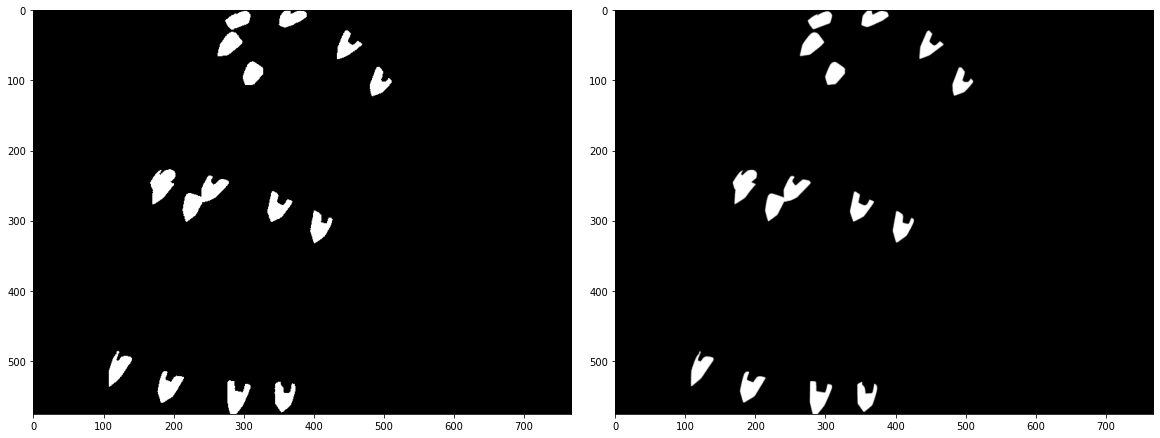

In [10]:
def transform(A: np.array, color: int, threshold: int) -> np.array:
    """
    Входные данные:
        A: матрица изображения
        color: цвет на который мы хотим поменять маску
        threshold: порог для обнуления пикселя
    Выходные данные:
        A: обработанная матрица
    """
    A[A <= threshold] = 0
    A[A > threshold] = color
    return A

# для демострации работы функции возьмем color = 255
# и порог threshold равный 10
mask_array = transform(mask_array, 255, 10)
new_mask = Image.fromarray(mask_array)

# запоминаем размеры изображений
height, width, _ = mask_array.shape
print(height, width)

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(new_mask)
axs[1].imshow(mask)

In [11]:
masks_dir = 'dataset/masks'
new_masks_dir = 'dataset/new_masks'

if not os.path.exists('dataset/new_masks'):
    os.mkdir('dataset/new_masks')

# применяем трансформацию ко всему датасету
# далее сохраняем в директории dataset/new_masks
for file in tqdm(os.listdir(masks_dir)):
    filename = os.fsdecode(file)
    if not filename.endswith('.png'):
      continue
    mask = Image.open(f"{masks_dir}/{filename}")
    mask_array = np.array(mask)
    new_mask_array = transform(mask_array, 1, 10)
    new_mask = Image.fromarray(mask_array)
    new_mask.save(f"{new_masks_dir}/{filename}")

100%|██████████| 240/240 [01:27<00:00,  2.75it/s]


In [8]:
mask = Image.open('dataset/new_masks/Image0001.png')
mask_array = np.array(mask)

show_pixel_values(mask_array)

{(0, 0, 0): 430320, (1, 1, 1): 12048}

Все пиксели равны либо $(0,0,0)$, либо $(1,1,1)$. Как и хотелось. Теперь обучим `vgg_unet` на тренировочном датасете.

In [10]:
imgs_dir = 'dataset/imgs'
masks_dir = 'dataset/new_masks'
checkpoints_dir = 'checkpoints/vgg_unet'
n_classes = 2
epochs = 3
batch_size = 2

model = vgg_unet(
            n_classes=n_classes,
            input_height=height,
            input_width=width
        )

model.train( 
    train_images=imgs_dir,
    train_annotations=masks_dir,
    checkpoints_path=checkpoints_dir,
    epochs=epochs,
    batch_size=batch_size, 
    optimizer_name="adam",
    gen_use_multiprocessing=True,
    auto_resume_checkpoint=True,
)

Verifying training dataset


100%|██████████| 240/240 [00:05<00:00, 44.45it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 515s 1s/step - loss: 0.0657 - accuracy: 0.9808
saved  checkpoints/vgg_unet.0
Epoch 2/3
512/512 [==============================] - 497s 970ms/step - loss: 0.0031 - accuracy: 0.9991
saved  checkpoints/vgg_unet.1
Epoch 3/3
512/512 [==============================] - 497s 971ms/step - loss: 0.0024 - accuracy: 0.9992
saved  checkpoints/vgg_unet.2


In [12]:
# загружаем модель с последного чекпойнта
model = model_from_checkpoint_path('checkpoints/vgg_unet')

58892288/58889256 [==============================] - 1s 0us/step
loaded weights  checkpoints/vgg_unet.2


In [13]:
test_dir = 'test/imgs'
result_dir = 'test/masks'

# предсказываем тестовый датасет
for file in tqdm(os.listdir(test_dir)):
    filename = os.fsdecode(file)
    image_name = f"{test_dir}/{filename}"
    out_name = f"{result_dir}/{filename[:-4]}.png"
    out = model.predict_segmentation(
        inp=image_name,
        out_fname=out_name
    )

100%|██████████| 80/80 [08:04<00:00,  6.06s/it]


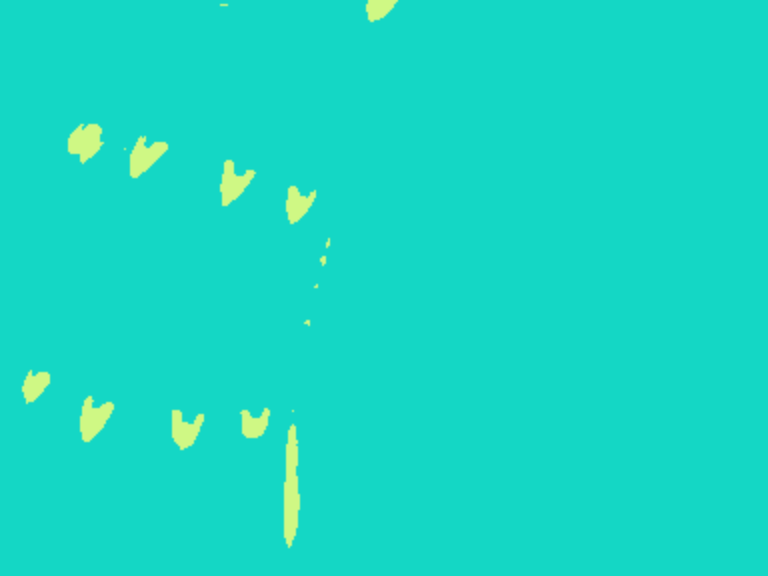

In [18]:
# посмотрим как выглядит предсказанная маска
ans = Image.open('test/masks/Image0161.png')
ans

In [15]:
ans_array = np.array(ans)
show_pixel_values(ans_array)

{(20, 215, 197): 432292,
 (32, 217, 193): 282,
 (55, 221, 185): 564,
 (67, 223, 181): 794,
 (102, 229, 169): 216,
 (125, 234, 160): 282,
 (160, 240, 148): 794,
 (172, 242, 144): 432,
 (195, 246, 136): 216,
 (207, 248, 132): 6496}

Как видим, пиксель $(20, 215, 197)$ соответствует фону. Остальные соответствуют маске. Сделаем функцию `detransform` которая будет обнулять (делать черными) пиксели в зависимости от того, насколько они отличаются от фона: если норма вектора разности заданного фона `bg` и рассматриваемого пикселя меньше определенного порога `threshold`, то делаем пиксель черным. Если нет, белым.

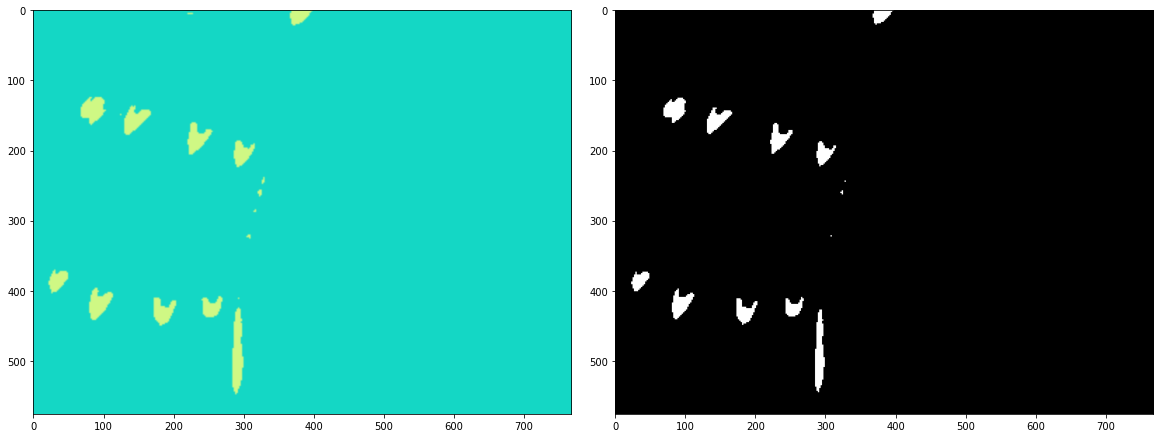

In [21]:
bg = (20, 215, 197)
threshold = 200

def detransform(A: np.array, bg: tuple, threshold: int) -> np.array:
    """
    Входные данные:
        A: матрица изображения
        bg: цвет заданного фона
        threshold: порог для обнуления пикселя
    Выходные данные:
        A: обработанная матрица
    """
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            norm = np.linalg.norm(A[i][j] - np.array(bg))
            if norm < threshold:
                A[i][j] = 0
    A[A != 0] = 255
    return A

ans = Image.open('test/masks/Image0161.png')
ans_array = np.array(ans)
detrans_ans_array = detransform(ans_array, bg, threshold)
trans_ans = Image.fromarray(detrans_ans_array)

# смотрим как детрансформировались изображения
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(ans)
axs[1].imshow(trans_ans)

In [22]:
masks_dir = 'test/masks'
new_masks_dir = 'test/new_masks'

if not os.path.exists('test/new_masks'):
    os.mkdir('test/new_masks')

# применяем обратную трансформацию к ответам
# далее сохраняем их в test/new_masks
for file in tqdm(os.listdir(masks_dir)):
    filename = os.fsdecode(file)
    if not filename.endswith('.png'):
        continue
    mask = Image.open(f"{masks_dir}/{filename}")
    mask_array = np.array(mask)
    new_mask_array = detransform(mask_array, bg, threshold)
    new_mask = Image.fromarray(mask_array)
    new_mask.save(f"{new_masks_dir}/{filename}")

100%|██████████| 81/81 [06:03<00:00,  4.48s/it]


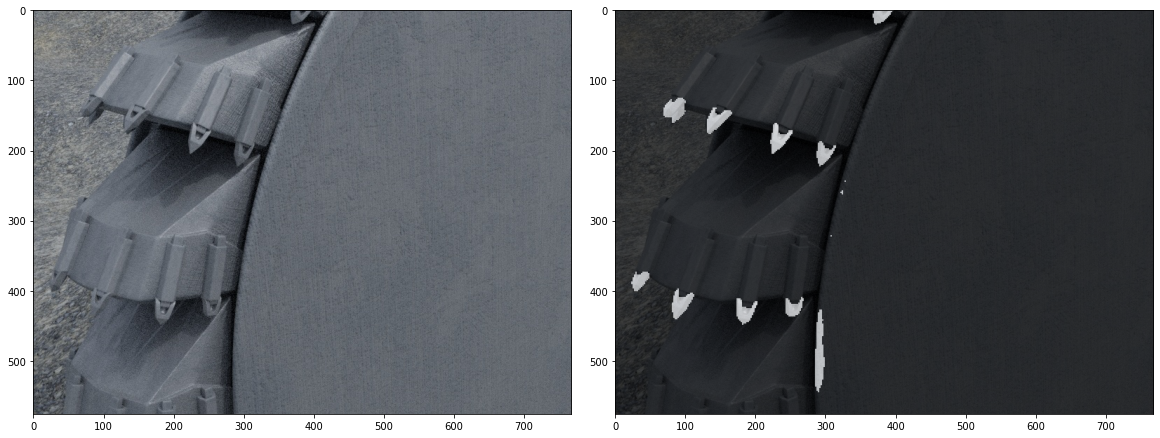

In [23]:
# смотрим на финальный результат сегментации
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

original = Image.open('test/imgs/Image0161.jpg')
mask = Image.open('test/new_masks/Image0161.png')

axs[0].imshow(original)
axs[1].imshow(original)
axs[1].imshow(mask, alpha=0.6)